# <font color='blue'>Data Science Academy - Deep Learning I</font>

# Multilayer Perceptron

### Implementação com TensorFlow 

http://yann.lecun.com/exdb/mnist/

## Compreendendo o Dataset

MNIST é um dataset que contém 70.000 imagens rotuladas de dígitos escritos à mão, conforme imagem abaixo.

![MNIST Data Sample](mnist-sample.png "MNIST Data Sample")

Nós vamos treinar um classificador linear em uma parte desse conjunto de dados e depois testar o classificador contra outra parte do conjunto de dados para avaliar a performance do nosso modelo. Para isso usaremos um modelo Multilayer Perceptron.

In [1]:
##########################
### Importando os Módulos
##########################
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
import input_data

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

In [2]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

In [3]:
tf.__version__

'2.1.0'

In [4]:
##########################
### DATASET
##########################
mnist = input_data.read_data_sets("/media/datasets/DeepLearningI/Cap04/MNIST", one_hot = True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


Esse procedimento já divide o conjunto de dados em três partes:

* Dataset de treino (55000 exemplos) usado para treinar o modelo
* Dataset de validação (5000 exemplos) usado para otimizar os hiperparâmetros 
* Dataset de test (10000 exemplos) usado para avaliar a precisão do modelo treinado

As imagens estão em escala de cinza e cada uma tem dimensão de 28 pixels de largura por 28 pixels de altura sendo armazenada em uma matriz de comprimento 784.

Os rótulos (labels) são um vetor * one hot * de comprimento 10, o que significa que é um vetor preenchido com zeros, exceto no local que corresponde ao rótulo a que se refere. Por exemplo. Uma imagem com label `3` será representada como `(0, 0, 0, 1, 0, 0, 0, 0, 0, 0)`.


In [5]:
print (mnist.train.images.shape)
print (mnist.train.labels.shape)

(55000, 784)
(55000, 10)


In [6]:
print (mnist.validation.images.shape)
print (mnist.validation.labels.shape)

(5000, 784)
(5000, 10)


In [7]:
print (mnist.test.images.shape)
print (mnist.test.labels.shape)

(10000, 784)
(10000, 10)


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


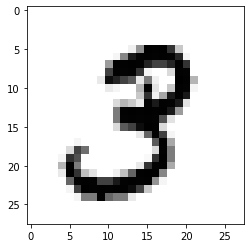

In [8]:
##########################
### Visualizando os Dados
##########################
example_image = mnist.train.images[1]
example_image_reshaped = example_image.reshape((28, 28))
example_label = mnist.train.labels[1]

print (example_label)
plt.imshow(example_image_reshaped)

## Arquitetura da Rede

Agora que compreendemos melhor o conjunto de dados com o qual estamos trabalhando, vamos passar para os bits de aprendizado de máquina.

In [9]:
##########################
### Configurações
##########################

# Hiperparâmetros
learning_rate = 0.1
training_epochs = 10
batch_size = 64

# Arquitetura
n_hidden_1 = 128
n_hidden_2 = 256
n_input = 784
n_classes = 10

## Definindo o Grafo Computacional

Primeiro, configuramos alguns espaços reservados (placeholders) para armazenar lotes desses dados de treinamento para quando treinarmos nosso modelo. A razão pela qual trabalhamos em lotes é que é mais fácil carregar na memória do que usar todo o conjunto. E é essa noção de trabalhar com lotes (aleatórios) de entrada ao invés de todo o conjunto que nos move do domínio de * Gradient Descent * que vimos anteriormente, para * Stochastic Gradient Descent * que temos aqui. Depois criamos as camadas, a função de perda e como vamos calcular as previsões.

Definiremos a inicialização de pesos e bias da seguinte forma:

````
W1 = tf.Variable(tf.zeros([784, 100]))
b1 = tf.Variable(tf.zeros([100]))
W2 = tf.Variable(tf.zeros([100, 10]))
b2 = tf.Variable(tf.zeros([10]))

````

Definimos também a nossa função de perda para medir a performance do modelo em imagens com rótulos conhecidos. Usamos a forma específica chamada de[cross entropy loss]

In [10]:
##########################
### Definição do Grafo no TensorFlow
##########################

g = tf.Graph()
with g.as_default():

    # Input data
    tf_x = tf.compat.v1.placeholder(tf.float32, [None, n_input], name = 'features')
    tf_y = tf.compat.v1.placeholder(tf.float32, [None, n_classes], name = 'targets')

    # Parâmetros do Modelo
    weights = {
        'w1': tf.Variable(tf.random.truncated_normal([n_input, n_hidden_1], stddev = 0.1)),
        'w2': tf.Variable(tf.random.truncated_normal([n_hidden_1, n_hidden_2], stddev = 0.1)),
        'out': tf.Variable(tf.random.truncated_normal([n_hidden_2, n_classes], stddev = 0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss e optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits(logits = out_layer, labels = tf.stop_gradient( tf_y))
    cost = tf.reduce_mean(input_tensor=loss, name = 'cost')
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train = optimizer.minimize(cost, name = 'train')

    # Previsões
    correct_prediction = tf.equal(tf.argmax(input=tf_y, axis=1), tf.argmax(input=out_layer, axis=1))
    accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32), name = 'accuracy')

## Treinando o modelo

De acordo com o funcionamento do TensorFlow, nós realmente não executamos nenhum dos códigos acima no sentido clássico. Tudo o que fizemos foi definir o que é chamado de grafo computacional.

Agora, vamos em frente e inicializamos uma sessão para realmente treinar o modelo e avaliar seu desempenho.

In [11]:
##########################
### Treinamento e Avaliação
##########################

with tf.compat.v1.Session(graph = g) as sess:

    sess.run(tf.compat.v1.global_variables_initializer())

    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            _, c = sess.run(['train', 'cost:0'], feed_dict = {'features:0': batch_x,
                                                              'targets:0': batch_y})
            avg_cost += c

        train_acc = sess.run('accuracy:0', feed_dict = {'features:0': mnist.train.images,
                                                        'targets:0': mnist.train.labels})

        valid_acc = sess.run('accuracy:0', feed_dict = {'features:0': mnist.validation.images,
                                                        'targets:0': mnist.validation.labels})

        print("Epoch: %03d | AvgCost: %.3f" % (epoch + 1, avg_cost / (i + 1)), end="")
        print(" | Acurácia em Treino/Validação: %.3f/%.3f" % (train_acc, valid_acc))

    test_acc = sess.run(accuracy, feed_dict = {'features:0': mnist.test.images,
                                               'targets:0': mnist.test.labels})

    print('Acurácia em Teste: %.3f' % test_acc)

Epoch: 001 | AvgCost: 0.348 | Acurácia em Treino/Validação: 0.933/0.936
Epoch: 002 | AvgCost: 0.166 | Acurácia em Treino/Validação: 0.962/0.959
Epoch: 003 | AvgCost: 0.120 | Acurácia em Treino/Validação: 0.972/0.968
Epoch: 004 | AvgCost: 0.094 | Acurácia em Treino/Validação: 0.980/0.974
Epoch: 005 | AvgCost: 0.077 | Acurácia em Treino/Validação: 0.982/0.973
Epoch: 006 | AvgCost: 0.064 | Acurácia em Treino/Validação: 0.985/0.976
Epoch: 007 | AvgCost: 0.054 | Acurácia em Treino/Validação: 0.987/0.975
Epoch: 008 | AvgCost: 0.046 | Acurácia em Treino/Validação: 0.988/0.976
Epoch: 009 | AvgCost: 0.038 | Acurácia em Treino/Validação: 0.992/0.977
Epoch: 010 | AvgCost: 0.033 | Acurácia em Treino/Validação: 0.992/0.977
Acurácia em Teste: 0.975


# Fim